# Data and Analysis Plan: Predicting DJ Sets Based on Tracklists 

- Justin Wee
- Aman Bhojwani
- Raul Sivaneindiren
- Pablo Roig

## Abstract

This project seeks to investigate the various factors influencing a DJ's choice of songs for their tracklist, focusing on the latest tracklists from renowned DJs Martin Garrix, Alesso, and Afrojack. We aim to identify the key sound attributes that DJs consider when selecting a track and to detect any discernible patterns in song attributes across their performances.  The ultimate goal is to develop a method for recommending the next song in a DJ's set akin to how Netflix employs viewer preferences and trends to suggest movies. Data for this study is primarily sourced from https://www.livetracklist.com, supplemented by the [Spotify API](https://developer.spotify.com/documentation/web-api),  and employing advanced data analysis techniques to potentially revolutionize song selection in DJ performances.


For DJs, sound factors play a major role in how they decide the flow of their sets and the transitions of their songs. DJs are able to cater to all different genres of music; however, they create specific sets based on the audience they are performing in front of. For example, when playing at a festival, a DJ chooses songs with higher danceability and tempo, as the intention for the crowd is to dance to the music. On the other hand, if the DJ is playing at a bar, they will choose songs with more acousticness or songs that can be sung along to, as the intention is for people to be sitting at their tables while they enjoy the music. Additionally, DJs also produce and release their own songs, which are key to incorporating into any set they play, as that is their own music by which people label them. Moreover, DJs can also assess the crowd's energy and age when choosing the songs to put on their tracklist, and use their knowledge of songs for the age group as well as analyze the various audio features to determine what songs the crowd will enjoy on the spot during their live set. By examining major DJs' tracklists and comparing them to the audio features of each song individually, there are optimal features that DJs use to add a song to their track list. We webscraped data from Live Track Lists for three big DJs (Martin Garrix, Alesso, and Afrojack), which contains their relevant tracklists updated every month to add to our models. We furthermore used the Spotify API to get the audio features of each song on their tracklist for further analysis. 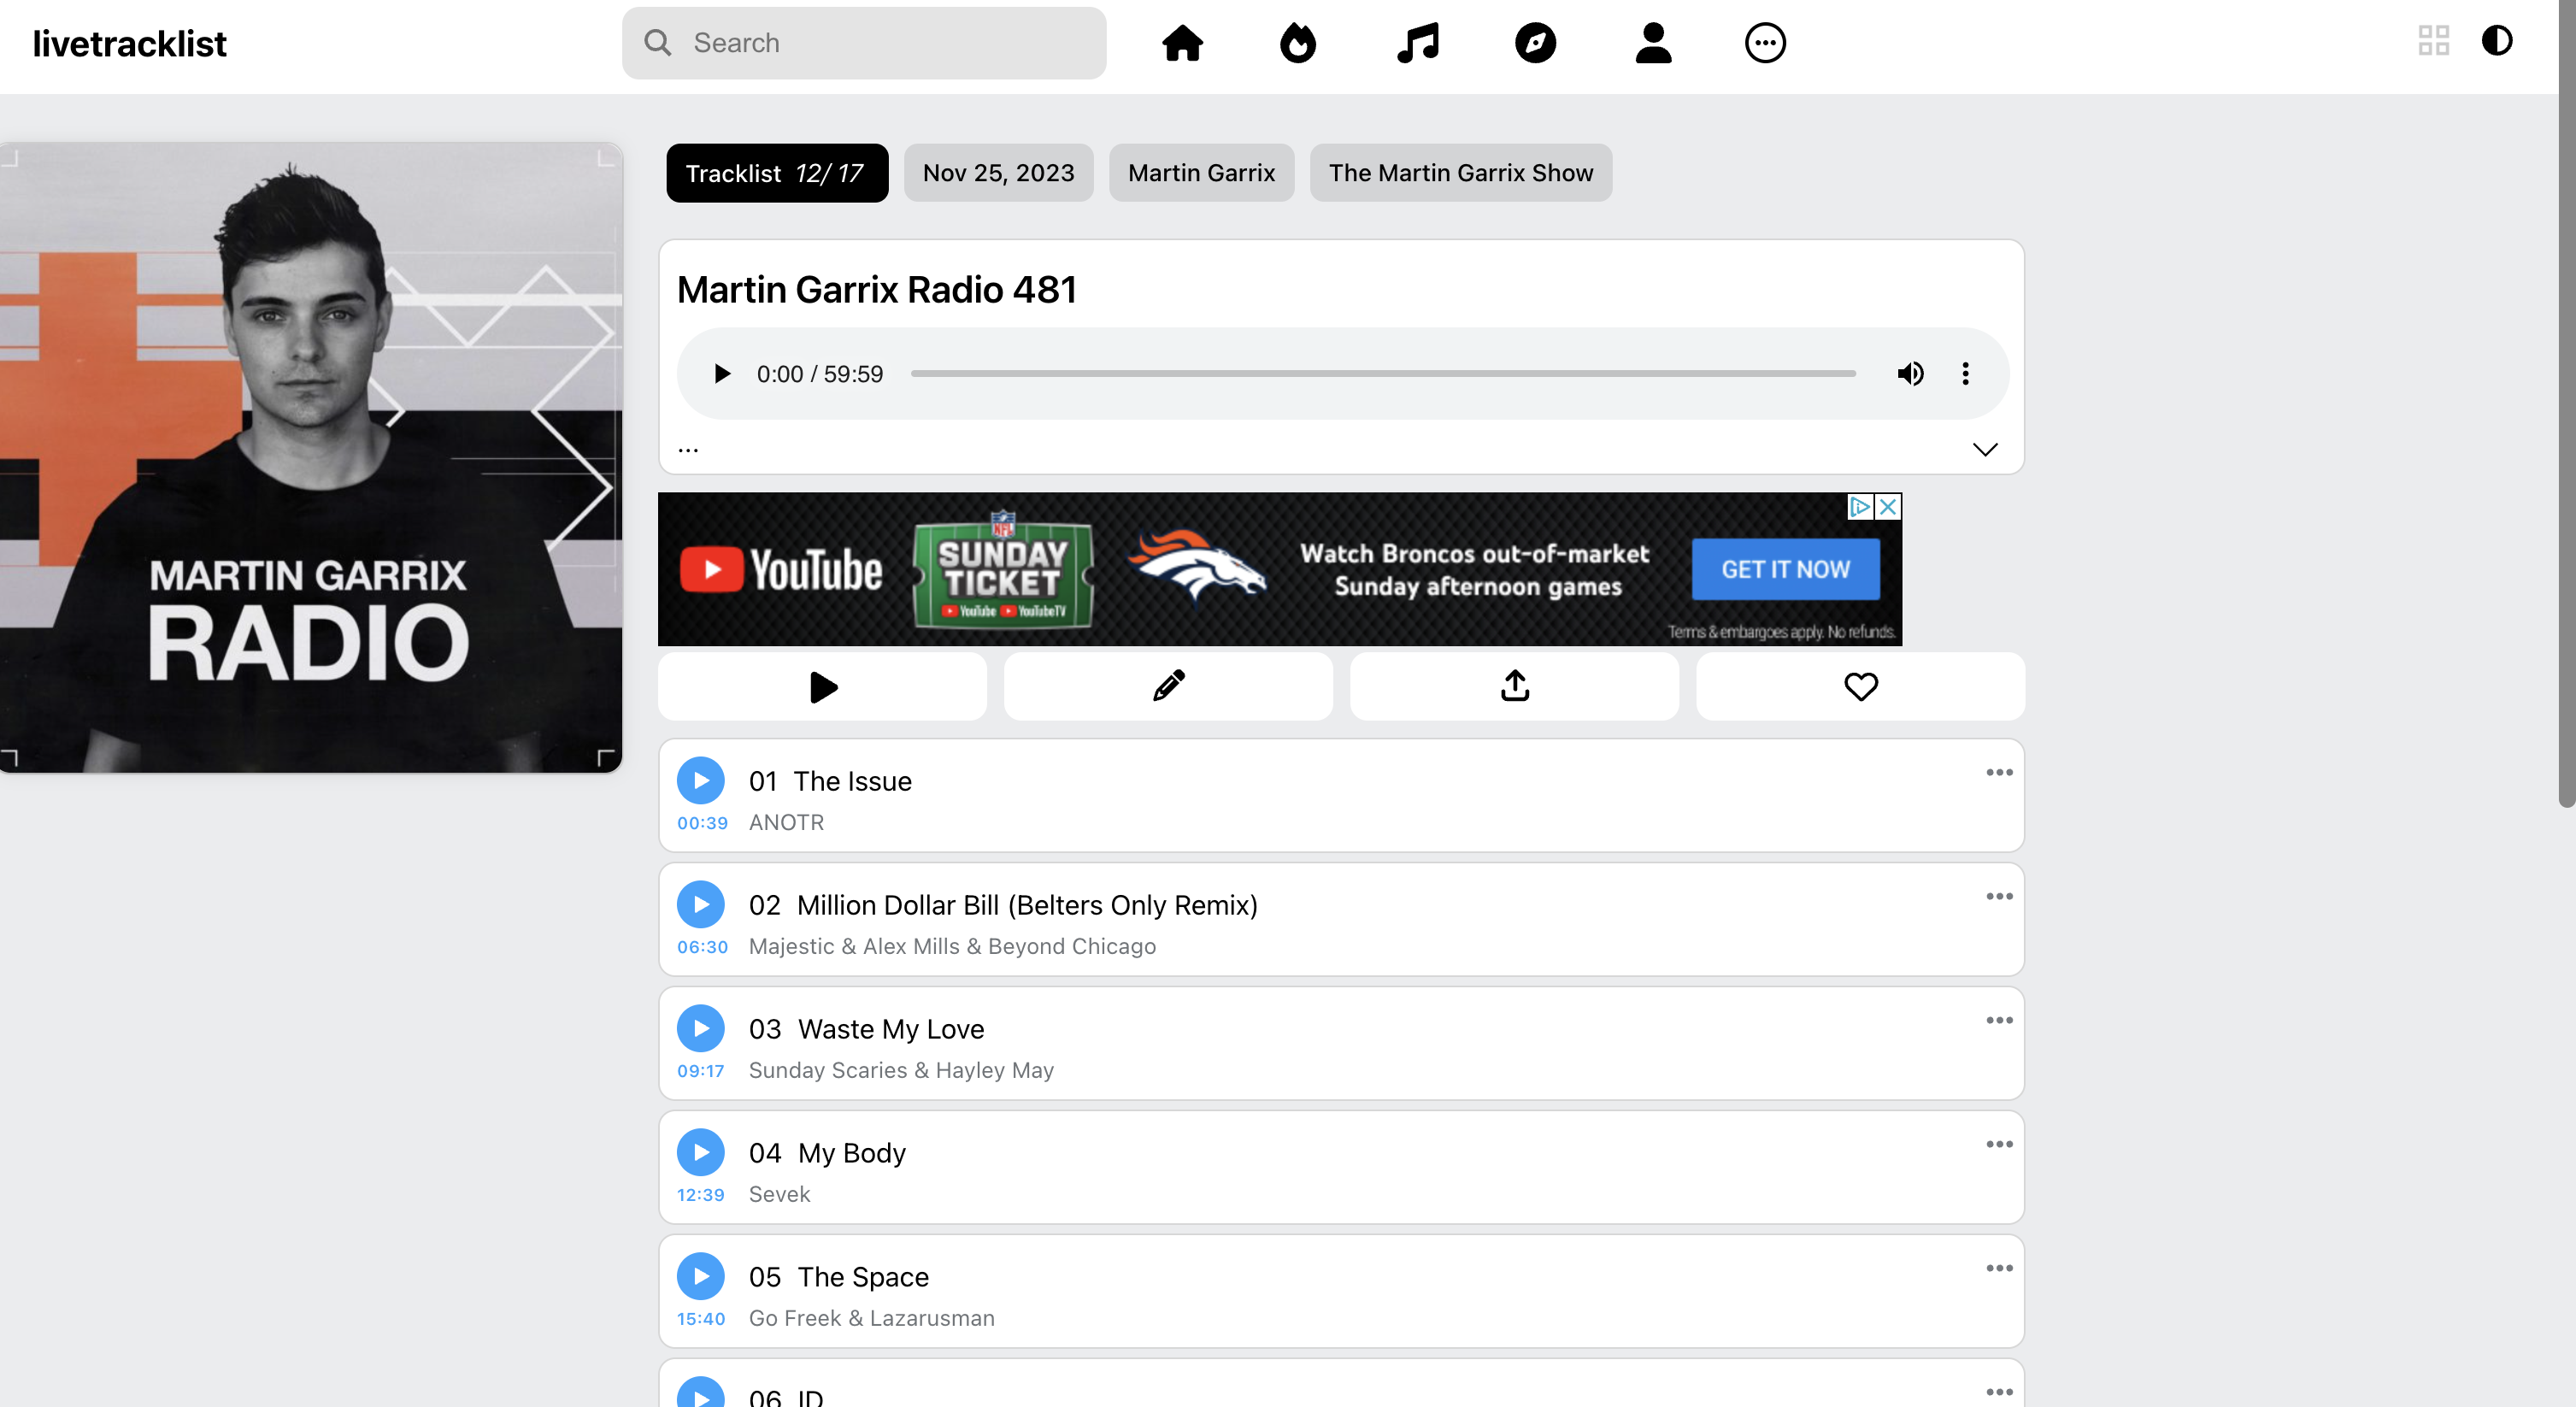

## Data Description

Our project comprises two distinct data streams: one for the DJs' tracklists and another for the corresponding audio features of each song on these tracklists.

For each DJ we are examining, we perform web scraping on the Live Tracklists website (as detailed above). We have obtained the most recent tracklists posted for each DJ (up to the point of our data analysis deadline). This information includes the tracklist's URL, DJ's name, song number, completion percentage, and the song name.

Regarding the corresponding Spotify API, we use Spotipy (Spotify's API for web developers) to obtain the audio features of each song from each DJ's tracklist. These API calls retrieve audio features including danceability, key, tempo, speechiness, acousticness, and many more. The data is then cleaned and appended to our results, forming a comprehensive dataset. This dataset includes the aforementioned features, along with additional details such as the Spotify URL, Spotify ID, track href, analysis URL, and time signature. The structure of the final dataframe is outlined below.



| tracklist                                      | song_num | percent_done | song_name    | dj            | danceability | energy | key | loudness | mode | liveness | tempo   | id                     | uri                                  |
|------------------------------------------------|----------|--------------|--------------|---------------|--------------|--------|-----|----------|------|----------|---------|------------------------|--------------------------------------|
| https://www.livetracklist.com/tracklist/martin | 1        | 6            | Fading Out   | Martin Garrix | 0.516        | 0.727  | 8   | -3.328   | 0    | 0.164    | 134.994 | 0xTV7zNJDDRmqOtwHiiKfL | spotify:track:0xTV7zNJDDRmqOtwHiiKfL |
| https://www.livetracklist.com/tracklist/martin | 2        | 11           | The Only One | Martin Garrix | 0.545        | 0.546  | 4   | -7.427   | 1    | 0.398    | 141.922 | 2hDGiGNj8DXkxO7AXj6oOX | spotify:track:2hDGiGNj8DXkxO7AXj6oOX |

In the example above:
- `tracklist` is the link to the website where the songs were scraped from.  
- `song_num` is the song number in the set, while `percent_done` is a simple calculation of the percentage of the set that is completed, by dividing the song number by the length of songs in that set.  
- `dj` is the name of the DJ whose set we are analyzing.  
- The rest of the columns signify the audio features we were able to get from the Spotify API.

## Project Goal:

Our project aims to explore the different factors that affect what songs a DJ may choose to play in his tracklist. We have chosen to focus on the three most recent tracklists from three popular DJs: Martin Garrix, Alesso, and Afrojack. Specifically, we ask:

- What are the optimal sound attributes that a DJ takes into account when adding a song to their tracklist?
- Are there any patterns that can be distinguished from a given song attribute over the course of a given DJ performance?
- Ultimately, is there a way to recommend what song should be played next on a DJ's set?

We are using https://www.livetracklist.com for our main data source in line with the Spotify API.

## Pipeline Overview:

For scraping from live tracklists website:
- tracklist_links()
    - gets the links from the three most recent tracklists of each DJ and stores this to a list of lists
  
- get_songs()
    - gets the names of the songs for each tracklist of each DJ based on the links in the previous function
    - stores all the songs in a single performance in a list, then stores each of these lists in a list with all three of a DJ's performances, and finally stores these in an outer list with all three DJs

For Spotify API:
- get_audio_features()
    - takes the track_id, song, and DJ and creates a dictionary consisting of the song name, DJ, and audio features (another dictionary given by the Spotify API)
    
- song_dict()
    - takes the big list given by get_songs() and creates a dictionary for each song in a given performance (from get_audio_features)
    - the list of dictionaries for a given performance is stored inside another list for each DJ
    
- flatten()
    - takes the list of list of dictionaries given by song_dict() and flattens the audio_features dictionary within the song dictionary so that all audio features have a key in the song dictionary rather than the audio features one
    - once all the dictionaries are flattened, turn the list of list of dictionaries into a DataFrame
   

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import requests
import pandas as pd
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import plotly.express as px
import numpy as np

In [2]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from spotify_secret import secret

# Authentication
cid = 'a0ce92dcdd084078964a4ba0e7cae446'

client_credentials_manager = SpotifyClientCredentials(client_id=cid, client_secret=secret)
sp = spotipy.Spotify(client_credentials_manager = client_credentials_manager)

### Web Scraping
`tracklist_links()` and `get_songs()`

These functions are responsible for scraping the website 'livetracklist.com' and creating a list of all songs in each of the three most recent sets of each of the DJs in a given list of DJs.

`tracklist_links()` takes a list of DJs and for each one, finds the link of the three most recent sets each of them have performed. 

`get_songs()` takes the list of these links and finds all songs in each set.


In [3]:
def tracklist_links(djs):
    """ takes a list of DJs and stores the link of the three most recent performances
        of each in a list of lists
        
    Args:
        djs (list): a list of DJs to find the link of tracklists for
        
    Returns:
        total_filtered (list): a list of lists with the three most recent performances for each DJ in djs
    
    """

    total_filtered = []
    
    # goes through each artist and gets the links of the three most recent performances
    for artist in djs:
        
        # searches up the artist and turns that page into a BeautifulSoup object
        url = f'https://www.livetracklist.com/artists/{artist}/'
        html = requests.get(url).text
        soup = BeautifulSoup(html)
        
        # finds all the links on the website and adds them to a list
        links = soup.find_all('a')
        link_list = []
        for i in links:
            i = i.get('href')
            link_list.append(i)
        
        # goes through each link in the list and finds unique tracklist links, then adds this to a final list
        filtered_links = []
        for link in link_list:
            if '/tracklist/' in link and link not in filtered_links:
                filtered_links.append(link)
        
        # only takes the three most recent links
        total_filtered.append(filtered_links[:3])
        
    return total_filtered
    

In [4]:
def get_songs(total_filtered):
    """ receives the link list of lists and finds each song in each link
    
    Args:
        total_filtered (list): a link list of lists, which are the three most recent performances of each DJ
        
    Returns:
        total_sets (list): a list of lists of all the songs in each tracklist, for each DJ
        
    """
    
    total_sets = []
    
    # loops three times for each DJ
    for i in range(3):
        total_songs = []
        
        # goes through each link of each DJ and turns that website into a BeautifulSoup object
        for link in total_filtered[i]:
            url = link
            html = requests.get(url).text
            soup = BeautifulSoup(html)
            
            # adds the link as the first element, then finds all the song titles 
            # and adds them to a list of songs for a given performance
            songs = soup.find_all(class_='title')
            song_list = []
            song_list.append(link)
            for i in songs:
                song_list.append(i.text)
            
            # adds this list of songs of a given performance to another list for each DJ
            total_songs.append(song_list)
        
        # adds each DJ list to a final list with all three DJs
        total_sets.append(total_songs)
        
    return total_sets

### Spotify API

### Finding Audio Features
`get_audio_features()` 

This function is responsible for getting the audio features of each song in each set by using the Spotify API, taking the song name and searching up/storing its audio features, which is what we will use to analyze.

In [5]:
def get_audio_features(track_id, song, dj):
    """ gets the audio features of a given song
    
    Args:
        track_id (str): the track id of a song from the Spotify API
        song (str): the name of the song
        dj (str): the name of the dj
        
    Returns:
        dict (dict): a dictionary with the song name, dj name, and 
                audio features (a dict given by the Spotify API)
                
    """
    
    # finds the audio features of a song from the track id
    audio_features = sp.audio_features(track_id)
    
    # returns the dictionary if there are audio features
    return {"song_name": song, "dj": dj, "audio_features": audio_features[0]} if audio_features else None

### Cleaning Song Data
`song_dict()` and `flatten()`

These functions are responsible for taking all features of each song in a list of songs and formatting them in a dictionary, and then eventually a DataFrame.

`song_dict()` takes all songs and combines song information with the `get_audio_features()` to create a dictionary with all relevant information of each song. This function creates a dictionary for each song in each set.

`flatten()` takes the list of list of dictionaries that `song_dict()` returns and cleans/formats the data to a singular DataFrame, which includes all relevant information for a given song per column and uses a different song for each row. The DataFrame can be easily read and interpreted, as well as utilized for more future analysis.

In [6]:
def song_dict(total_songs):
    """ takes the list of list of songs for each set, for each DJ and turns it 
        into a list of list of dictionaries with all the audio features for each song
        
    Args:
        total_songs (list): a list of lists with the songs for each set, for each DJ
        
    Returns:
        list_all (list of dict): a list of list of dicts, with the dicts being the audio features for each song
            and these dictionaries being inside a list for a given set, then three of these lists 
            inside another list for a given DJ
            
    """
    list_all = []

    # goes through each artist number in the list of lists
    for artist_num in range(len(total_songs)):

        set_list = []
        
        # goes through each set number in the list
        for set_num in range(len(total_songs[artist_num])):

            audio_feat_list = []
            
            # goes through each song in a given setlist
            for song in total_songs[artist_num][set_num][1:]:
                
                # searches the song on the Spotify API by its name
                results = sp.search(q=song, type="track")
                
                # if there is a song that matches, get its track id and audio features using the above function
                if results and results['tracks']['items']:
                    track_id = results['tracks']['items'][0]['id']
                    audio_features = get_audio_features(track_id, song, djs[artist_num])
                    
                    # creates a link key where the link of the tracklist is in the dict
                    audio_features['link'] = total_songs[artist_num][set_num][0]
                    
                    # if there are audio features for this song, add it to a list 
                    # with all other songs in a given set
                    if audio_features:
                        audio_feat_list.append(audio_features)
            
            # add this list to another list for each DJs
            set_list.append(audio_feat_list)
        
        # add this setlist to a final list with all three DJs
        list_all.append(set_list)

    return list_all

In [7]:
def flatten(list_all):
    """ takes the list of list of dictionaries and flattens the audio features dictionary, 
        then turns this into a DataFrame
        
    Args:
        list_all (list of list of dict): the list containing the audio features 
        for each song, in each set, for each DJ
        
    Returns:
        df_tracklist (pd.DataFrame): a DataFrame with all the audio features of all 
        the songs in each set for each DJ
    
    """
    
    flattened_data = []

    # goes through each artist number in the list of lists
    for artist_num in range(len(list_all)):

        # goes through each set number in the list
        for set_num in range(len(list_all[artist_num])):
            
            # goes through each dictionary of features in the list and makes a new dictionary for each song
            # with all the audio features being in the same dictionary and not in a dict of dicts
            for item, i in zip(list_all[artist_num][set_num], range(len(list_all[artist_num][set_num]))):
                if item['audio_features']:
                    flattened_item = {
                        'tracklist': item['link'],
                        'set_num': set_num + 1,
                        'song_num': i + 1,
                        'percent_done': (round((i + 1)/len(list_all[artist_num][set_num]), 2) * 100),
                        'song_name': item['song_name'],
                        'dj': item['dj']
                    }
                    flattened_item.update(item['audio_features'])
                    flattened_data.append(flattened_item)

    # create the DataFrame
    df_tracklist = pd.DataFrame(flattened_data)
    df_tracklist.drop(['type', 'id', 'uri', 'track_href', 'analysis_url'], axis=1, inplace=True)
    
    return df_tracklist

In [8]:
djs = ['martin-garrix', 'alesso', 'afrojack']

total_filtered = tracklist_links(djs)
total_songs = get_songs(total_filtered)

list_all = song_dict(total_songs)
df_tracklist = flatten(list_all)

In [9]:
df_tracklist

,tracklist,set_num,song_num,percent_done,song_name,dj,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,https://www.livetracklist.com/tracklist/martin...,1,1,6.0,The Issue,martin-garrix,0.680,0.484,9,-8.750,1,0.1910,0.092200,0.00000,0.0940,0.268,180.033,178680,4
1,https://www.livetracklist.com/tracklist/martin...,1,2,12.0,Million Dollar Bill (Belters Only Remix),martin-garrix,0.710,0.864,11,-7.137,0,0.0359,0.009180,0.56800,0.2100,0.729,126.989,174214,4
2,https://www.livetracklist.com/tracklist/martin...,1,3,18.0,Waste My Love,martin-garrix,0.710,0.776,10,-7.697,0,0.0315,0.198000,0.00902,0.0728,0.333,122.984,197073,4
3,https://www.livetracklist.com/tracklist/martin...,1,4,24.0,My Body,martin-garrix,0.649,0.476,1,-7.754,1,0.3640,0.165000,0.00000,0.0937,0.364,77.191,186982,4
4,https://www.livetracklist.com/tracklist/martin...,1,5,29.0,The Space,martin-garrix,0.406,0.730,9,-6.278,1,0.0315,0.047100,0.00000,0.2290,0.207,170.032,242000,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
219,https://www.livetracklist.com/tracklist/afroja...,3,19,83.0,Bounce Generation (Chasner & NLW Edit),afrojack,0.687,0.998,2,-1.304,1,0.2910,0.000476,0.04310,0.3290,0.129,128.007,152813,4
220,https://www.livetracklist.com/tracklist/afroja...,3,20,87.0,"Mind Awake, Body Asleep",afrojack,0.741,0.849,1,-7.755,1,0.0874,0.251000,0.62500,0.1630,0.265,133.938,150448,4
221,https://www.livetracklist.com/tracklist/afroja...,3,21,91.0,Temptations,afrojack,0.512,0.362,0,-9.661,1,0.0267,0.545000,0.00133,0.0813,0.364,131.427,365720,3
222,https://www.livetracklist.com/tracklist/afroja...,3,22,96.0,Stompin,afrojack,0.832,0.706,7,-4.970,1,0.3300,0.072300,0.00000,0.8840,0.683,127.977,195209,4


In [10]:
# creating subset DataFrames for each set of each DJ
df_garrix = df_tracklist[df_tracklist['dj'] == 'martin-garrix']
df_garrix_1 = df_garrix[df_garrix['set_num'] == 1]
df_garrix_2 = df_garrix[df_garrix['set_num'] == 2]
df_garrix_3 = df_garrix[df_garrix['set_num'] == 3]


df_alesso = df_tracklist[df_tracklist['dj'] == 'alesso']
df_alesso_1 = df_alesso[df_alesso['set_num'] == 1]
df_alesso_2 = df_alesso[df_alesso['set_num'] == 2]
df_alesso_3 = df_alesso[df_alesso['set_num'] == 3]


df_afro = df_tracklist[df_tracklist['dj'] == 'afrojack']
df_afro_1 = df_afro[df_afro['set_num'] == 1]
df_afro_2 = df_afro[df_afro['set_num'] == 2]
df_afro_3 = df_afro[df_afro['set_num'] == 3]

## Graphs
### Danceability

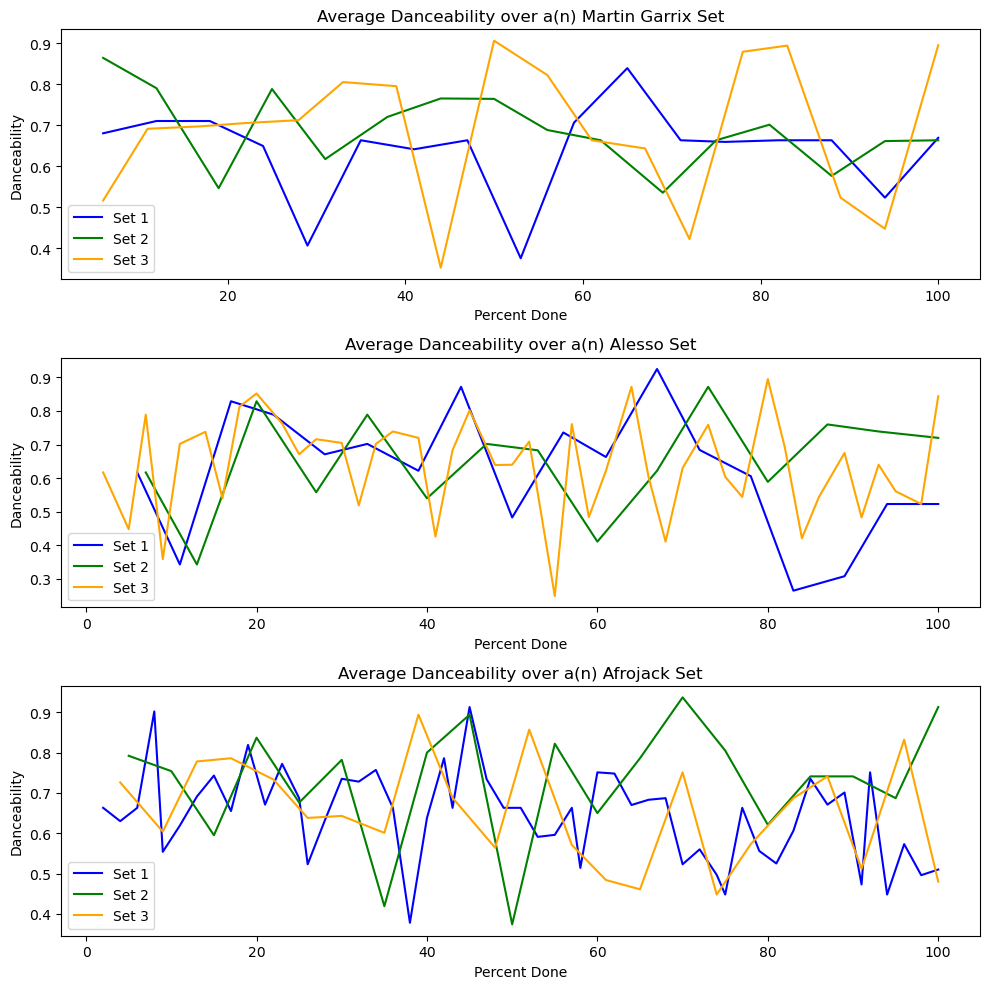

In [11]:
# dictionary of list of dataframes for each set of each DJ
data = {
        'Martin Garrix': [df_garrix_1, df_garrix_2, df_garrix_3],
        'Alesso': [df_alesso_1, df_alesso_2, df_alesso_3],
        'Afrojack': [df_afro_1, df_afro_2, df_afro_3]
}

# determine subplot arrangement
fig, axs = plt.subplots(3, 1, figsize=(10, 10))

# flattening the axis array for easy indexing
axs = axs.flatten()

# loop through the data and create each subplot
for i, (key, df) in enumerate(data.items()):
    
    # plotting the line in a vibrant color
    axs[i].plot(df[0]['percent_done'], df[0]['danceability'], color='blue', label='Set 1')
    axs[i].plot(df[1]['percent_done'], df[1]['danceability'], color='green', label='Set 2')
    axs[i].plot(df[2]['percent_done'], df[2]['danceability'], color='orange', label='Set 3')


    # set titles and labels
    axs[i].set_title(f'Average Danceability over a(n) {key} Set')
    axs[i].set_xlabel('Percent Done')
    axs[i].set_ylabel('Danceability')
    axs[i].legend()

# adjust layout to prevent overlap
plt.tight_layout()

# show plot
plt.show()

### Tempo

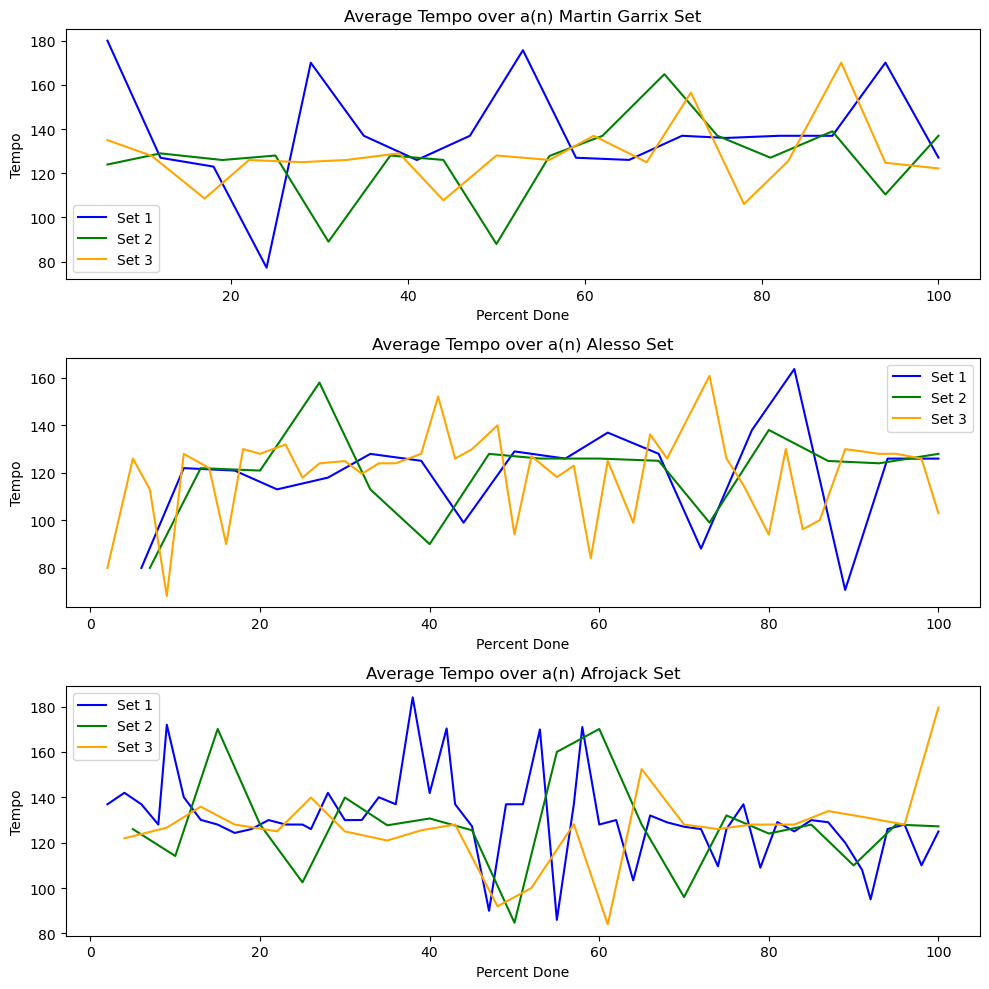

In [12]:
# determine subplot arrangement
fig, axs = plt.subplots(3, 1, figsize=(10, 10))

# flattening the axis array for easy indexing
axs = axs.flatten()

# loop through the data and create each subplot
for i, (key, df) in enumerate(data.items()):
    
    # plotting the line in a vibrant color
    axs[i].plot(df[0]['percent_done'], df[0]['tempo'], color='blue', label='Set 1')
    axs[i].plot(df[1]['percent_done'], df[1]['tempo'], color='green', label='Set 2')
    axs[i].plot(df[2]['percent_done'], df[2]['tempo'], color='orange', label='Set 3')


    # set titles and labels
    axs[i].set_title(f'Average Tempo over a(n) {key} Set')
    axs[i].set_xlabel('Percent Done')
    axs[i].set_ylabel('Tempo')
    axs[i].legend()

# adjust layout to prevent overlap
plt.tight_layout()

# show plot
plt.show()

### Key

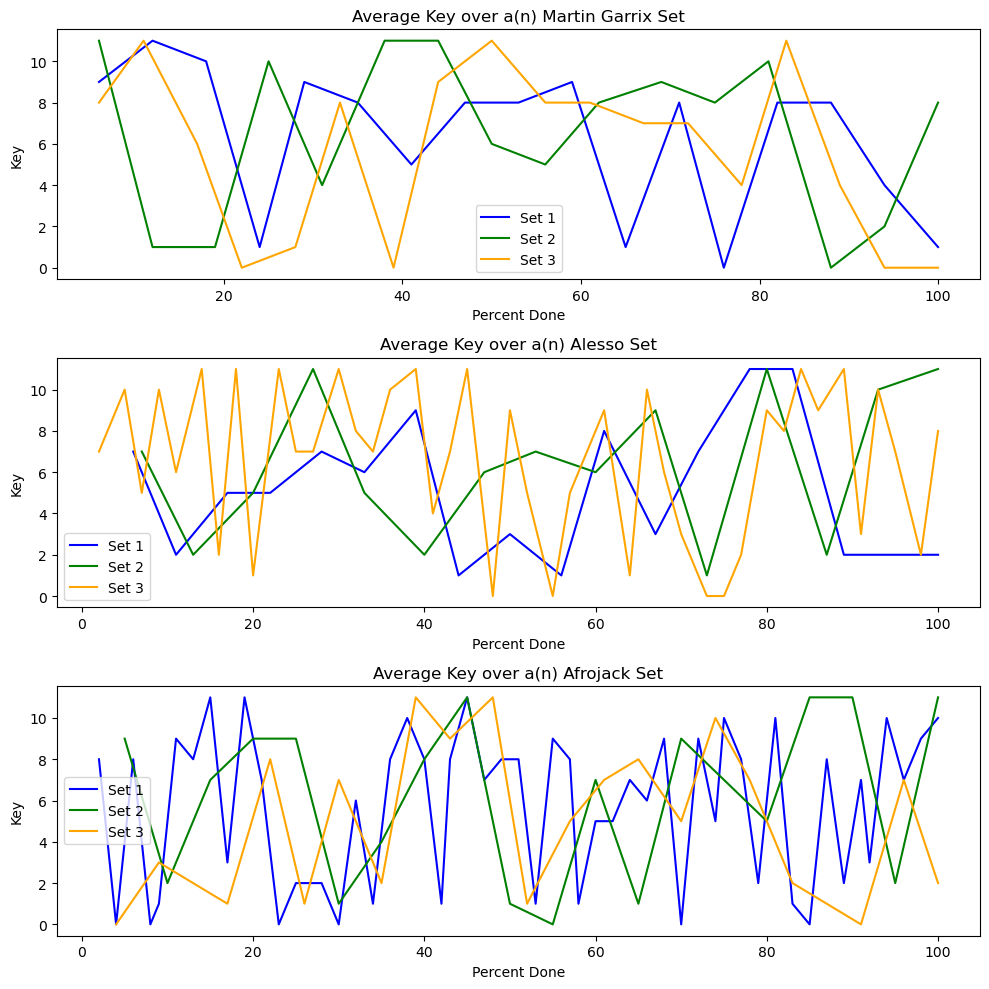

In [13]:
# determine subplot arrangement
fig, axs = plt.subplots(3, 1, figsize=(10, 10))

# flattening the axis array for easy indexing
axs = axs.flatten()

# loop through the data and create each subplot
for i, (key, df) in enumerate(data.items()):
    
    # plotting the line in a vibrant color
    axs[i].plot(df[0]['percent_done'], df[0]['key'], color='blue', label='Set 1')
    axs[i].plot(df[1]['percent_done'], df[1]['key'], color='green', label='Set 2')
    axs[i].plot(df[2]['percent_done'], df[2]['key'], color='orange', label='Set 3')


    # set titles and labels
    axs[i].set_title(f'Average Key over a(n) {key} Set')
    axs[i].set_xlabel('Percent Done')
    axs[i].set_ylabel('Key')
    axs[i].legend()

# adjust layout to prevent overlap
plt.tight_layout()

# show plot
plt.show()

# Method

With the data now cleaned and prepared, we can begin to use machine learning models to analyze this data and see if we are able to accurately predict certain audio features of the next song in a DJ's set. For this project, we have decided to predict the tempo.

Although we originally chose to do a Decision Tree Classifier, we found that we mostly had quantitative variables rather than categorical variables, which is what Decision Trees excel in. Therefore, we have chosen to use a Regression Model, as we believe this method to be the most appropriate in predicting the exact tempo number value of the next song based on the given audio features. 

Because we have so many different DataFrames, one for each set of the three DJs, we needed to find a way to train and test the model on each of these sets independently, take their predictions, and then somehow concatenate or collapse all these predictions to create a method where we can understand the efficacy of the model across all sets.

Therefore, we have decided to approach this by finding the average accuracy score across all models by taking the average of all MSEs and R-squared values; hopefully, this will give us a good indication of how successful the model was at predicting the next song's tempo in a set.

### Linear Regression

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

MSE: 194521.15538815688
R-squared: -501.7475256637322


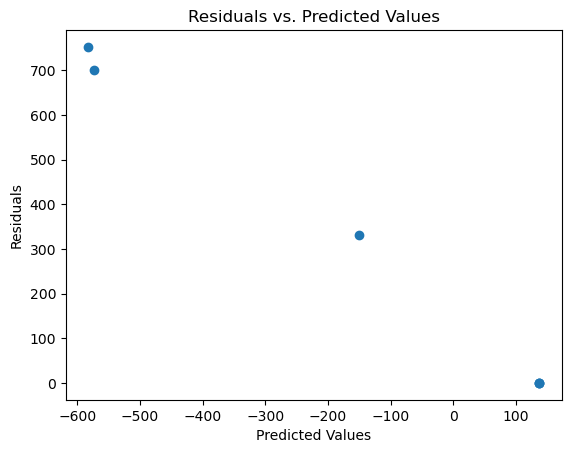

MSE: 4076.260072384989
R-squared: -46.37488323365147


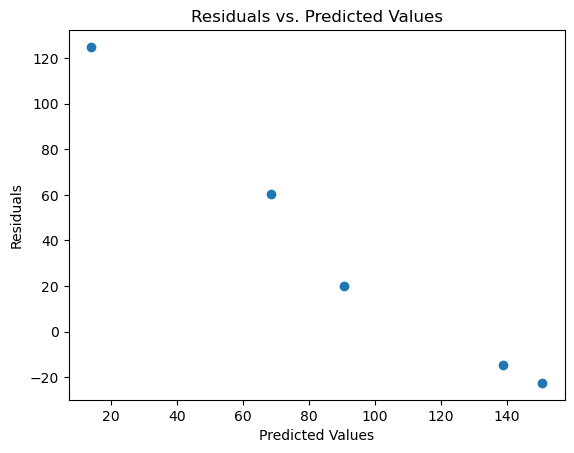

MSE: 1315.4399516428855
R-squared: -15.501918228277098


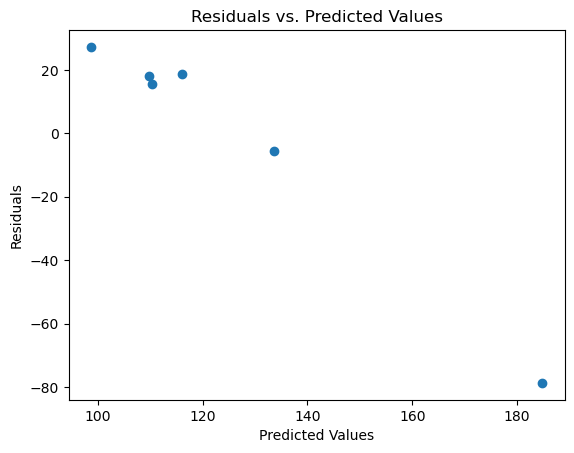

MSE: 1721.9279170230545
R-squared: -3.8897277950470768


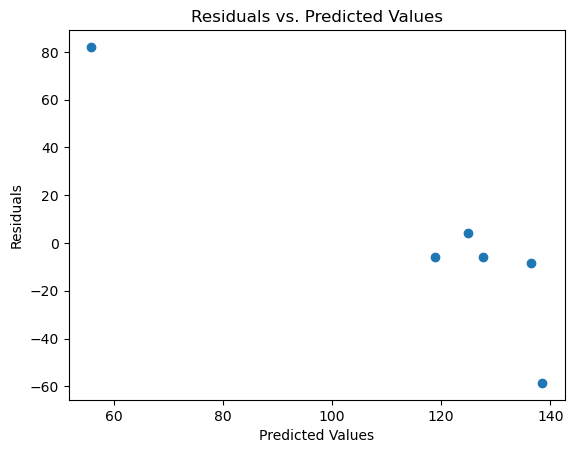

MSE: 4590.572631007099
R-squared: -8.143219164052155


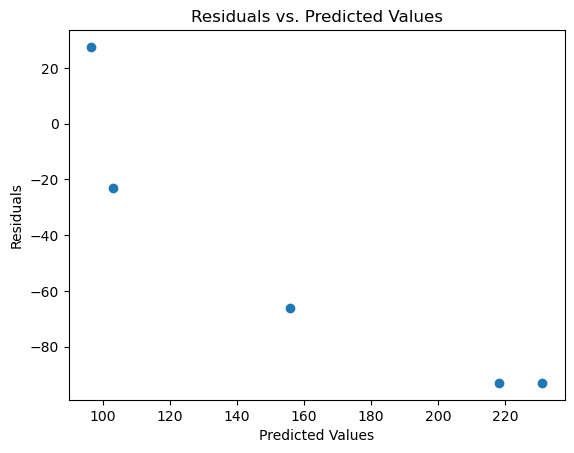

MSE: 1053.7454515764036
R-squared: -0.879808152551961


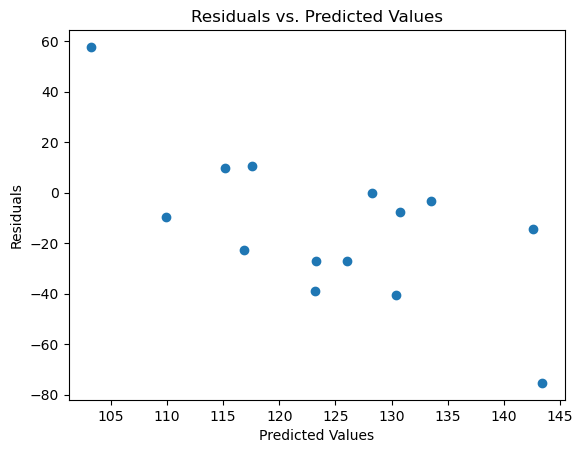

MSE: 911.1392632900764
R-squared: -1.5489759027292136


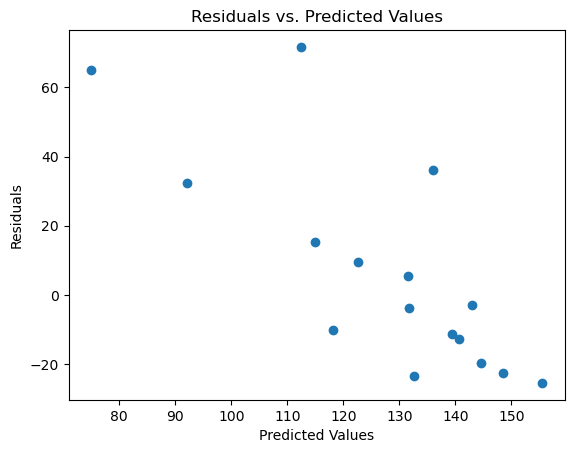

MSE: 4549.293341347208
R-squared: -48.62516992337078


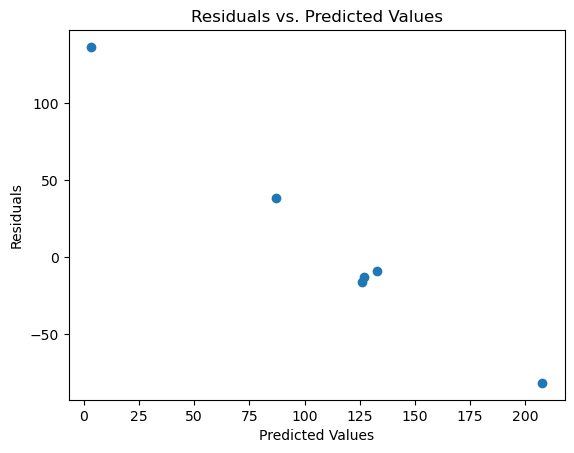

MSE: 462.40141890523756
R-squared: -101.99655115330567


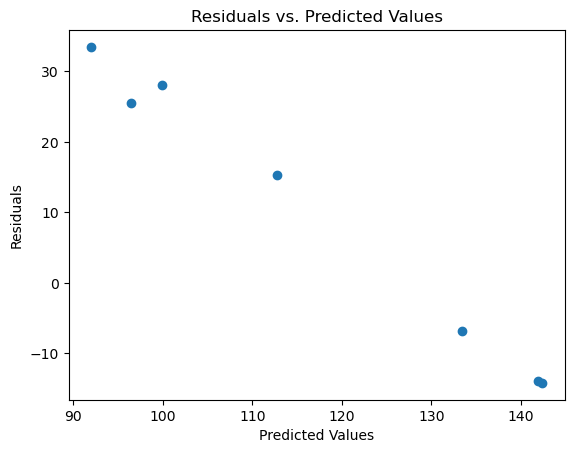

In [16]:
# list of all sets
list_dfs = [df_garrix_1, df_garrix_2, df_garrix_3, df_alesso_1, df_alesso_2, df_alesso_3, 
            df_afro_1, df_afro_2, df_afro_3]

# list of predictive features
features = ['danceability', 'energy', 'key', 'loudness', 'speechiness', 'acousticness',
            'instrumentalness', 'liveness', 'valence']

# goes through each set and predicts the tempo of the song in the test set
for df in list_dfs:
    
    # split data into features (X) and target label (y)
    X = df[features]
    y = df['tempo']
    
    # splits the X and y arrays into training and test splits (70-30 split)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    # scales the features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    # fit the model to the training data
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    # predict the tempo of the test data with the fitted model
    y_pred = model.predict(X_test)
    
    # calculates MSE and R-squared values, then prints them
    resids = y_test - y_pred
    mse = np.mean(resids**2)
    r2 = r2_score(y_test, y_pred)
    
    print(f'MSE: {mse}')
    print(f'R-squared: {r2}')
    
    
    # plots residuals against predicted values
    plt.scatter(y_pred, resids)
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.title(f'Residuals vs. Predicted Values')
    plt.show()
    

### Logistic Regression (Category)

After trying the Multiple Regression model, we realized that the accuracy of the model was far more inaccurate than we had hoped for. So, we will try a Logistic Regression model that categorizes tempo into three different categories: Slow (under 100), Medium (100-140), and Fast (over 140).

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [18]:
# target variable
def categorize_tempo(tempo):
    if tempo <= 100:
        return 'Slow'
    elif tempo <= 140:
        return 'Medium'
    return 'Fast'

In [19]:
# list of all sets
list_dfs = [df_garrix_1, df_garrix_2, df_garrix_3, df_alesso_1, df_alesso_2, df_alesso_3, 
            df_afro_1, df_afro_2, df_afro_3]

# list of predictive features
features = ['danceability', 'energy', 'key', 'loudness', 'speechiness', 'acousticness',
            'instrumentalness', 'liveness', 'valence']

# goes through each set and predicts the tempo of the song in the test set
for df in list_dfs:
    df_new = df.copy()
    df_new['tempo'] = df['tempo'].apply(categorize_tempo)

    # split data into features (X) and target label (y)
    X = df_new[features]
    y = df_new['tempo']
    
    # splits the X and y arrays into training and test splits (70-30 split)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    # scales the features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    # fit the model to the training data
    model = LogisticRegression()
    model.fit(X_train, y_train)
    
    # predict the tempo of the test data with the fitted model and print the accuracy score
    y_pred = model.predict(X_test)
    score = accuracy_score(y_test, y_pred)

    print(f'Accuracy Score: {round(score *100, 2)}%')

Accuracy Score: 66.67%
Accuracy Score: 100.0%
Accuracy Score: 100.0%
Accuracy Score: 50.0%
Accuracy Score: 60.0%
Accuracy Score: 50.0%
Accuracy Score: 56.25%
Accuracy Score: 83.33%
Accuracy Score: 100.0%


# Discussion

From the machine learning models we have presented today, we can see that there is not enough evidence that suggests a machine learning model is accurate enough to be able to predict the exact tempo value of the next song in a DJ set. However, we found that it may be plausible for a machine learning model to predict the category of a given tempo, be it Slow, Medium, or Fast. There are some potential reasonings for this conclusion.

Firstly, we think that one of the reasons why a machine learning model is unable to predict the exact tempo value is because there was not a strong discernible pattern between tempo and other features; therefore, regardless of the features that were used to try and predict the tempo, it could never really predict the exact number. This can be seen in the subplots below, where we plotted the relationship between tempo and all the features we used. As you can see, there is not much patterning or trends that are distinct between any of these features and the tempo. This gives us the impression that it would have been difficult, regardless of the model, to predict the tempo without any sense of patterning.

Secondly, we think that neither model was able to predict the exact tempo value because the tempo itself had no discernible pattern. In other words, the range was so large that it was hard to be even in the ballpark of what tempo the next song needed to be. Maybe this was due to the wrong data being selected (i.e. a different set by a different DJ may have worked better) or the song audio features being incorrect (Spotify API searching up the wrong song). Regardless, this was an oversight in our model which we would take into account next time we have to do a prediction model.

In response to these restrictions, we decided to try to categorize songs into different 'buckets' based on their tempo. This was much more successful, having an accuracy score (correct predictions divided by total predictions) of at least 50% across all sets and up to even 100% for a set. This seemed to be far easier and much more intuitive than the previous model, as instead of trying to find the *exact* tempo, we were predicting within a range. Some limitations of this model arose too, however:
1. If our goal was to ultimately predict the next song in a DJ set, finding only the category of tempo it is in wouldn't be as useful as finding the exact value.
2. The ranges for Slow and Fast were extremely broad; <100 BPM and >140 BPM. There are many songs that fall far outside of these categories, such as less than 60 BPM and over 180 BPM. It would be in our best interest to create more categories next time in order for us to have a better understanding of how accurate our model really is.

This project is definitely a work in progress, and there are many things we could do to improve our predictions in the future. These are just some pieces of insight and methods of improvement that we thought of that could have been implemented to improve the model.

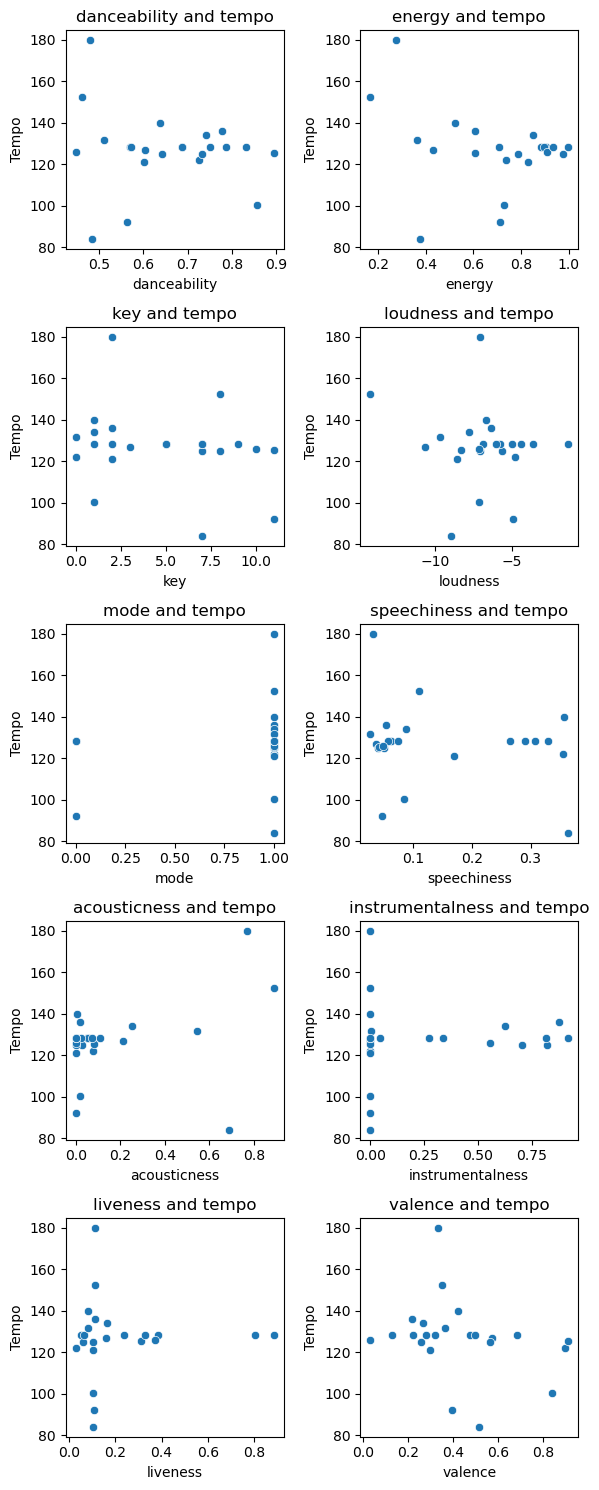

In [20]:
import seaborn as sns

# list of all features
features = ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness',
            'instrumentalness', 'liveness', 'valence']

# number of rows/columns for the subplot grid
n_rows = len(features) // 2
n_cols = 2

# Create a figure and a grid of subplots
plt.figure(figsize=(6, 3 * n_rows))
for i, feature in enumerate(features, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.scatterplot(x=df[feature], y=df['tempo'])
    plt.title(f'{feature} and tempo')
    plt.xlabel(feature)
    plt.ylabel('Tempo')

# Adjust layout and show plot
plt.tight_layout()
plt.show()

## Takeaway

We feel that if we were to have more accurate data, we could have a better chance at predicting the tempo and possibly other values in the dataset. We think that the Spotify API did not do as well of a job as we would have liked in searching up the name of the song, particularly because DJs do not only play released songs, but unreleased and 'project' songs that may not be in the Spotify database. However, this is something that we cannot control; therefore, we feel that the only way we could improve the model would be to look at other regression models or machine learning models that would possibly better fit the data, or possibly transform the tempo value to 'buckets' as we have done in order to give a wider range of values for the model to correctly predict. Otherwise, we think that this project gave us great insight into how machine learning can be used in everyday life, even in something like music festivals and DJ sets.